# NPOD at Future Colliders

## Imports and Definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from scipy.signal import savgol_filter
from scipy.constants import physical_constants
from scipy.ndimage import gaussian_filter

from helperFunctions import *

In [2]:
# plot settings, increase font sizes
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.framealpha'] = 1

## Primakoff Production Cross-Section

In [3]:
# load preprocessed cross-section data
masses = np.load('data/primakoffXsec.npz')['masses']
beamEnergies = np.load('data/primakoffXsec.npz')['beamEnergies']
crossSection = np.load('data/primakoffXsec.npz')['crossSection']

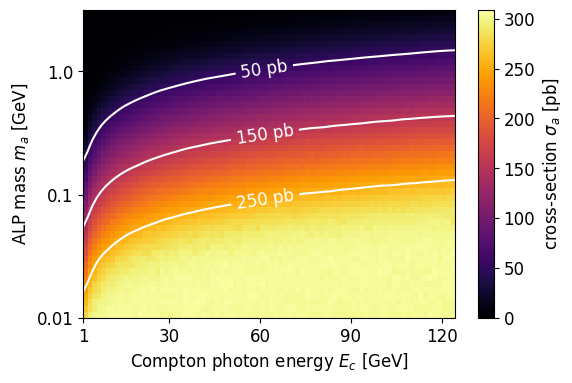

In [4]:
with plt.rc_context(regu):

    fig, ax = plt.subplots()
    
    cax = ax.pcolormesh(crossSection, cmap='inferno')
    
    fig.colorbar(cax, label=r'cross-section $\sigma_a$ [pb]')
    
    cs = ax.contour(gaussian_filter(crossSection, sigma=1), levels=[50,150,250], colors='white', linestyles='-')
    
    manual_locations = [(40,40),(40,30),(40,20)]
    ax.clabel(cs, cs.levels, fmt='%d pb', manual=manual_locations)
    
    xtick_idx = np.argwhere(np.isin(beamEnergies, [1.5,30,60,90,120])).flatten()
    ax.set(xlabel=r'Compton photon energy $E_c$ [GeV]', xticks=xtick_idx, xticklabels=beamEnergies[xtick_idx].astype(int), xlim=(0,len(beamEnergies)-1))
    
    ytick_idx = np.argwhere(np.isin(masses, [0.01,0.1,1.0])).flatten()
    ax.set(ylabel='ALP mass $m_a$ [GeV]', yticks=ytick_idx, yticklabels=masses[ytick_idx], ylim=(0,len(masses)-1))
    
    plt.show()

## Photon Spectra

In [5]:
# FCCee intensity control
data = np.load('data/spectra/fccee_ic.npz')
ic_rate = data['rate']
ic_weights = data['weights']
ic_energy = data['energy']

# FCCee injector
data = np.load('data/spectra/fccee_injector.npz')
ij_rate = data['rate']
ij_weights = data['weights']
ij_energy = data['energy']

# XFEL low-intensity laser (LUXE-NPOD)
data = np.load('data/spectra/xfel_luxe.npz')
xl_rate = data['rate']
xl_weights = data['weights']
xl_energy = data['energy']

# XFEL high-intensity laser
data = np.load('data/spectra/xfel_optimized.npz')
xh_rate = data['rate']
xh_weights = data['weights']
xh_energy = data['energy']

# ILC-like
data = np.load('data/spectra/ilc.npz')
ilc_rate = data['rate']
ilc_weights = data['weights']
ilc_energy = data['energy']

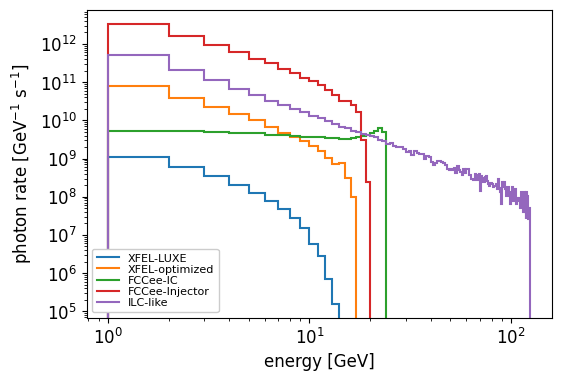

In [6]:
with plt.rc_context(regu):

    bins = np.arange(1, 125+0.01, 1)
    
    fig, ax = plt.subplots()

    ax.stairs(*np.histogram(xl_energy, bins, weights=xl_weights*xl_rate), lw=1.5, label='XFEL-LUXE')
    ax.stairs(*np.histogram(xh_energy, bins, weights=xh_weights*xh_rate), lw=1.5, label='XFEL-optimized')
    ax.stairs(*np.histogram(ic_energy, bins, weights=ic_weights*ic_rate), lw=1.5, label='FCCee-IC')
    ax.stairs(*np.histogram(ij_energy, bins, weights=ij_weights*ij_rate), lw=1.5, label='FCCee-Injector')
    ax.stairs(*np.histogram(ilc_energy, bins, weights=ilc_weights*ilc_rate), lw=1.5, label='ILC-like')

    ax.legend(loc='lower left')
    ax.set(xlabel='energy [GeV]', ylabel='photon rate [GeV$^{-1}$ s$^{-1}$]', xscale='log', yscale='log')
    plt.show()

## Background Estimates

In [7]:
Ld_luxe = 1
L_nuc = 0.1

xl_mask = xl_energy>1
xh_mask = xh_energy>1
ic_mask = ic_energy>1
ij_mask = ij_energy>1
ilc_mask = ilc_energy>1

xl_int = xl_rate*np.sum(xl_energy[xl_mask]*xl_weights[xl_mask])
xh_int = xh_rate*np.sum(xh_energy[xh_mask]*xh_weights[xh_mask])
ic_int = ic_rate*np.sum(ic_energy[ic_mask]*ic_weights[ic_mask])
ij_int = ij_rate*np.sum(ij_energy[ij_mask]*ij_weights[ij_mask])
ilc_int = ilc_rate*np.sum(ilc_energy[ilc_mask]*ilc_weights[ilc_mask])

print('minimum dump length:')

Ld_xh = Ld_luxe - L_nuc * np.log(xl_int / xh_int)
print(f'XFEL-optimized:\t{Ld_xh:.2f} m')

Ld_ic = Ld_luxe - L_nuc * np.log(xl_int / ic_int)
print(f'FCCee-IC:\t{Ld_ic:.2f} m')

Ld_ij = Ld_luxe - L_nuc * np.log(xl_int / ij_int)
print(f'FCCee-Injector:\t{Ld_ij:.2f} m')

Ld_ilc = Ld_luxe - L_nuc * np.log(xl_int / ilc_int)
print(f'ILC-like:\t{Ld_ilc:.2f} m')

minimum dump length:
XFEL-optimized:	1.44 m
FCCee-IC:	1.51 m
FCCee-Injector:	1.83 m
ILC-like:	1.68 m


## Event Boundaries

In [8]:
clN = 3

debug = False

filePath = 'data/lcf/benchmark/'

setupFile = filePath + 'setup.npz'

L_d = np.load(setupFile)['L_d'][()]
L_v = np.load(setupFile)['L_v'][()]

R_max = np.load(setupFile)['R_max'][()]
E_min = np.load(setupFile)['E_min'][()]

L_eff_pb = np.load(setupFile)['L_eff_pb'][()]
#L_eff_pb *= 15

n_norm = np.load(setupFile)['n_norm'][()]
n_sim = np.load(setupFile)['n_sim'][()]

G_A = np.load(setupFile)['G_A'][()]

masses = np.load(setupFile)['masses'][()]
beamEnergies = np.load(setupFile)['beamEnergies'][()]

crossSection = np.load(setupFile)['crossSection'][()]

massGrid, couplingGrid = np.meshgrid(masses, G_A)

if debug:
    print(beamEnergies.shape)
    print(masses.shape)
    print(crossSection.shape)


phaseSpace = np.zeros((len(G_A),len(masses)))
for i,m_a in enumerate(masses[:]):

    Ndet = np.load(filePath+f'npodSignal_signalEvents_ma{m_a:08.6f}GeV.npz')['Ndet']
    
    # scale the number of detected events from the simulation to 1 electron
    N_events = Ndet * n_norm[beamEnergies>m_a,np.newaxis] / n_sim[beamEnergies>m_a,np.newaxis]
    
    # scale the number of detected events by the effective luminosity
    N_events = L_eff_pb * N_events
    
    # scale the number of detected events by the cross-section for each coupling
    N_events = N_events.T * scaleCS(crossSection[i,beamEnergies>m_a], 1/G_A[:,np.newaxis], 1e4)
    
    # sum over the beam energies
    N_events = np.nansum(N_events, axis=1)
    phaseSpace[:,i] = N_events
    
# flip the data to match the matshow pattern
phaseSpace += phaseSpace[phaseSpace.nonzero()].min()*np.array(phaseSpace==0)

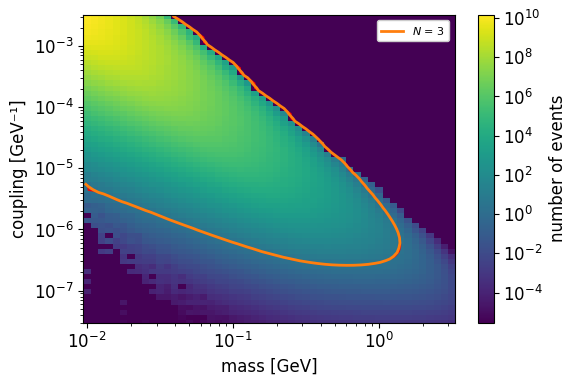

In [9]:
# plot the data
with plt.rc_context():

    fig, ax = plt.subplots(figsize=(6,4))
    
    im = ax.pcolormesh(massGrid, couplingGrid, phaseSpace, norm=LogNorm(), cmap='viridis')
    cs = ax.contour(massGrid, couplingGrid, phaseSpace, levels=[clN], colors='r', linewidths=1)
    
    cont = cs.get_paths()[0].vertices.T
    
    cont = savgol_filter(cont[0], 4, 1, mode='interp'), savgol_filter(cont[1], 4, 1, mode='interp')
    ax.plot(*cont, '-', c='C1', lw=2, label='$N$ = {}'.format(clN))
    
    #np.save(filePath+'npodSignal_limit.npy', cont)

    fig.colorbar(im, label='number of events')
    ax.legend()
    ax.set(xlabel='mass [GeV]', ylabel='coupling [GeV⁻¹]', xscale='log', yscale='log')
    plt.gca().set_aspect('auto')
    plt.show()

## Phase-Space

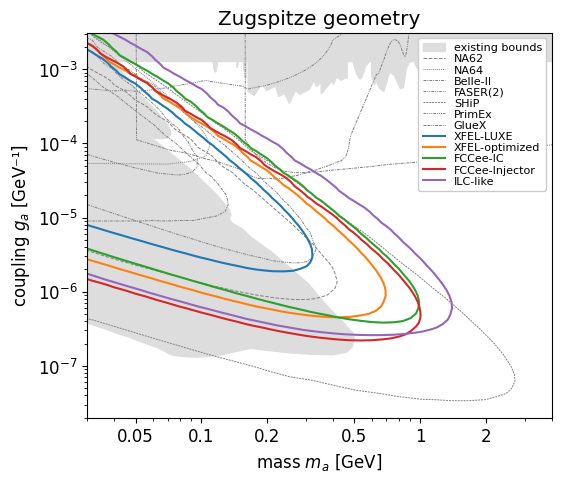

In [10]:
with plt.rc_context(regu):

    fig, ax = plt.subplots(figsize=(6,5))

    ###########################
    # EXISTING CONSTRAINTS
    ###########################

    ax.fill(np.nan, np.nan, c='#DDD', label='existing bounds')
    plotConstraints(ax, 'beamdumps')
    plotConstraints(ax, 'opal_2017')
    plotConstraints(ax, 'primex_2019')
    plotConstraints(ax, 'na64_2020')
    plotConstraints(ax, 'belle2_2020')    
    plotConstraints(ax, 'bes3_2023')    
    plotConstraints(ax, 'miniboone_2023')    
    plotConstraints(ax, 'faser_2025')

    ###########################
    # PROJECTIONS
    ###########################
    
    plotConstraints(ax, 'na62_1e18pot')
    plotConstraints(ax, 'na64_5e12eot')
    plotConstraints(ax, 'belle2_proj')
    plotConstraints(ax, 'faser_proj')
    plotConstraints(ax, 'ship_proj')
    plotConstraints(ax, 'primex_proj')
    plotConstraints(ax, 'gluex_fb')

    ###########################
    # FUTURE FACILITIES
    ###########################

    data = np.load('data/xfel/luxe/benchmark/npodSignal_limit.npy')
    ax.plot(*data, 'C0-', lw=1.5, label=r'XFEL-LUXE')

    data = np.load('data/xfel/optimized/benchmark/npodSignal_limit.npy')
    ax.plot(*data, 'C1-', lw=1.5, label=r'XFEL-optimized')

    data = np.load('data/fcc/intensityControl/benchmark/npodSignal_limit.npy')
    ax.plot(*data, 'C2-', lw=1.5, label=r'FCCee-IC')

    data = np.load('data/fcc/injector/benchmark/npodSignal_limit.npy')
    ax.plot(*data, 'C3-', lw=1.5, label=r'FCCee-Injector')

    data = np.load('data/lcf/benchmark/npodSignal_limit.npy')
    ax.plot(*data, 'C4-', lw=1.5, label=r'ILC-like')

    
    ax.legend(loc='upper right', fontsize=8, framealpha=1, labelcolor='k', labelspacing=0.1)
    ax.set(title='Zugspitze geometry', 
           xlabel='mass $m_a$ [GeV]', xscale='log', xlim=(3e-2, 4e0), 
           xticks=(0.05, 0.1, 0.2, 0.5, 1, 2), xticklabels=('0.05', '0.1', '0.2', '0.5', '1', '2'),
           ylabel='coupling $g_a$ [GeV⁻¹]', yscale='log', ylim=(2e-8, 3.1e-3))
    
    plt.show()

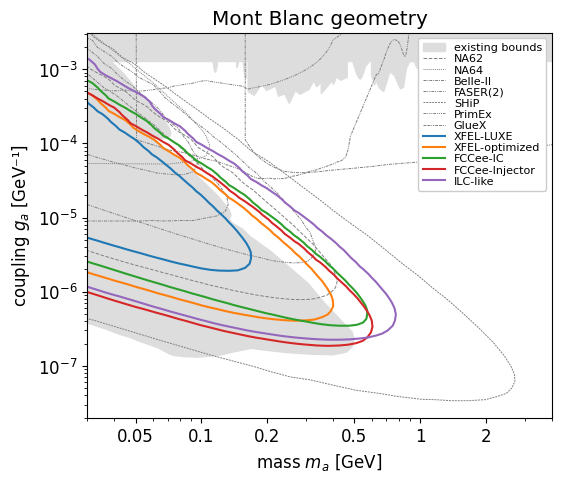

In [11]:
with plt.rc_context(regu):

    fig, ax = plt.subplots(figsize=(6,5))

    ###########################
    # EXISTING CONSTRAINTS
    ###########################
    
    ax.fill(np.nan, np.nan, c='#DDD', label='existing bounds')
    plotConstraints(ax, 'beamdumps')
    plotConstraints(ax, 'opal_2017')
    plotConstraints(ax, 'primex_2019')
    plotConstraints(ax, 'na64_2020')
    plotConstraints(ax, 'belle2_2020')    
    plotConstraints(ax, 'bes3_2023')    
    plotConstraints(ax, 'miniboone_2023')    
    plotConstraints(ax, 'faser_2025')  

    ###########################
    # PROJECTIONS
    ###########################
    
    plotConstraints(ax, 'na62_1e18pot')
    plotConstraints(ax, 'na64_5e12eot')
    plotConstraints(ax, 'belle2_proj')
    plotConstraints(ax, 'faser_proj')
    plotConstraints(ax, 'ship_proj')
    plotConstraints(ax, 'primex_proj')
    plotConstraints(ax, 'gluex_fb')

    ###########################
    # FUTURE FACILITIES
    ###########################
    
    data = np.load('data/xfel/luxe/shipLike/npodSignal_limit.npy')
    ax.plot(*data, 'C0-', lw=1.5, label=r'XFEL-LUXE')

    data = np.load('data/xfel/optimized/shipLike/npodSignal_limit.npy')
    ax.plot(*data, 'C1-', lw=1.5, label=r'XFEL-optimized')

    data = np.load('data/fcc/intensityControl/shipLike/npodSignal_limit.npy')
    ax.plot(*data, 'C2-', lw=1.5, label=r'FCCee-IC')

    data = np.load('data/fcc/injector/shipLike/npodSignal_limit.npy')
    ax.plot(*data, 'C3-', lw=1.5, label=r'FCCee-Injector')

    data = np.load('data/lcf/shipLike/npodSignal_limit.npy')
    ax.plot(*data, 'C4-', lw=1.5, label=r'ILC-like')
    
    ax.legend(loc='upper right', fontsize=8, framealpha=1, labelcolor='k', labelspacing=0.1)
    ax.set(title='Mont Blanc geometry', 
           xlabel='mass $m_a$ [GeV]', xscale='log', xlim=(3e-2, 4e0), 
           xticks=(0.05, 0.1, 0.2, 0.5, 1, 2), xticklabels=('0.05', '0.1', '0.2', '0.5', '1', '2'),
           ylabel='coupling $g_a$ [GeV⁻¹]', yscale='log', ylim=(2e-8, 3.1e-3))
    
    plt.show()

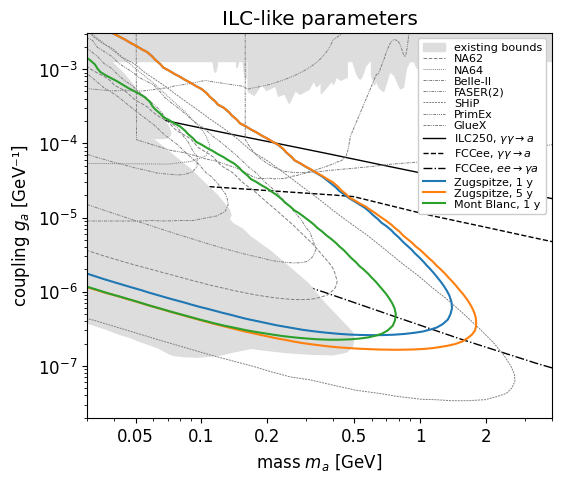

In [12]:
with plt.rc_context(regu):

    fig, ax = plt.subplots(figsize=(6,5))


    ###########################
    # EXISTING CONSTRAINTS
    ###########################
    
    ax.fill(np.nan, np.nan, c='#DDD', label='existing bounds')
    plotConstraints(ax, 'beamdumps')
    plotConstraints(ax, 'opal_2017')
    plotConstraints(ax, 'primex_2019')
    plotConstraints(ax, 'na64_2020')
    plotConstraints(ax, 'belle2_2020')    
    plotConstraints(ax, 'bes3_2023')    
    plotConstraints(ax, 'miniboone_2023')    
    plotConstraints(ax, 'faser_2025')

    ###########################
    # PROJECTIONS
    ###########################
    
    plotConstraints(ax, 'na62_1e18pot')
    plotConstraints(ax, 'na64_5e12eot')
    plotConstraints(ax, 'belle2_proj')
    plotConstraints(ax, 'faser_proj')
    plotConstraints(ax, 'ship_proj')
    plotConstraints(ax, 'primex_proj')
    plotConstraints(ax, 'gluex_fb')


    ###########################
    # FUTURE FACILITIES
    ###########################

    data = np.genfromtxt('data/limit_data/projections/ilc_250GeV.txt', delimiter=', ').T
    ax.plot(*data, 'k-', lw=1, label=r'ILC250, $\gamma \gamma \to a$', zorder=-1)

    data = np.genfromtxt('data/limit_data/projections/fccee_91GeV_yy2a.txt', delimiter=', ').T
    ax.plot(*data, 'k--', lw=1, label=r'FCCee, $\gamma \gamma \to a$', zorder=-1)

    data = np.genfromtxt('data/limit_data/projections/fccee_ee2ya.txt', delimiter=', ').T
    ax.plot(*data, 'k-.', lw=1, label=r'FCCee, $e e \to \gamma a$', zorder=-1)

    data = np.load('data/lcf/benchmark/npodSignal_limit.npy')
    ax.plot(*data, 'C0-', lw=1.5, label=r'Zugspitze, 1 y')
    
    data = np.load('data/lcf/benchmark/npodSignal_limit_5years.npy')
    ax.plot(*data, 'C1-', lw=1.5, label=r'Zugspitze, 5 y')

    data = np.load('data/lcf/shipLike/npodSignal_limit.npy')
    ax.plot(*data, 'C2-', lw=1.5, label=r'Mont Blanc, 1 y')
    
    ax.legend(loc='upper right', fontsize=8, framealpha=1, labelcolor='k', labelspacing=0.1)
    ax.set(title='ILC-like parameters', 
           xlabel='mass $m_a$ [GeV]', xscale='log', xlim=(3e-2, 4e0), 
           xticks=(0.05, 0.1, 0.2, 0.5, 1, 2), xticklabels=('0.05', '0.1', '0.2', '0.5', '1', '2'),
           ylabel='coupling $g_a$ [GeV⁻¹]', yscale='log', ylim=(2e-8, 3.1e-3))
    
    plt.show()